In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import umap
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import warnings
warnings.filterwarnings("ignore")

c:\Users\PRABHAKAR VENKAT\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('cleaned_churn.csv')
df

,Unnamed: 0,Phone_Number,Account_Length,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn
0,0,382-4657,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,1,371-7191,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,2,358-1921,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,3,330-6626,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
4,4,391-8027,118,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36028,36072,796-5759,228,0,222.8,92,29.82,280.0,202,22.28,268.6,229,22.09,9.6,2,2.89,2,False
36029,36073,779-7579,62,0,228.8,92,29.88,292.8,92,26.88,222.9,89,9.62,20.2,2,2.82,8,False
36030,36074,789-9756,222,0,228.2,60,22.82,229.8,289,28.26,222.8,222,2.28,6.2,2,2.62,2,False
36031,36075,798-5885,88,0,282.2,222,82.88,208.8,220,22.82,282.2,200,20.68,9.8,8,2.82,8,False


In [3]:
# Ensure 'Churn' column is properly formatted
df['Churn'] = df['Churn'].astype(int)

# Select relevant numerical columns for clustering
numerical_cols = [
    'Account_Length', 'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 
    'Eve_Mins', 'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 
    'Night_Charge', 'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls'
]

X = df[numerical_cols]

In [4]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Dimensionality Reduction using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_scaled)

In [6]:
# Perform hierarchical clustering
linkage_matrix = linkage(X_umap, method='ward')
df['Cluster'] = fcluster(linkage_matrix, t=3, criterion='maxclust') - 1  # t=3 specifies 3 clusters

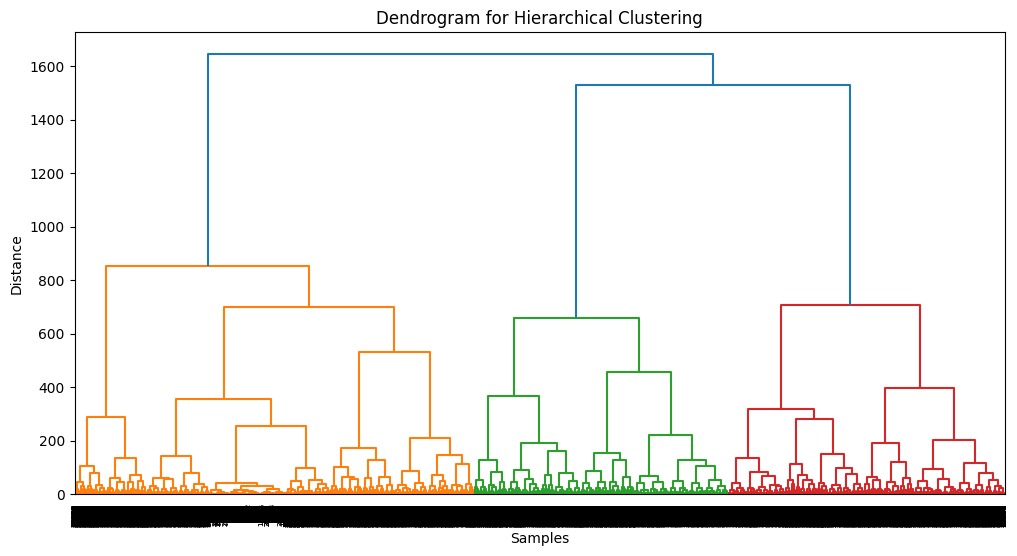

In [7]:
# Visualize the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

In [8]:
# Visualize the clusters using UMAP components
df['UMAP1'] = X_umap[:, 0]
df['UMAP2'] = X_umap[:, 1]

In [9]:
# Calculate Customer Lifetime Value (CLV)
df['CLV'] = df['Day_Charge'] + df['Eve_Charge'] + df['Night_Charge'] + df['Intl_Charge']

# Define cluster names based on your analysis
cluster_names = {
    0: 'Potential Low Value Customers',
    1: 'Potential Medium Value Customers',
    2: 'Potential High Value Customers'
}

# Map clusters to descriptive names
df['Cluster_Name'] = df['Cluster'].map(cluster_names)

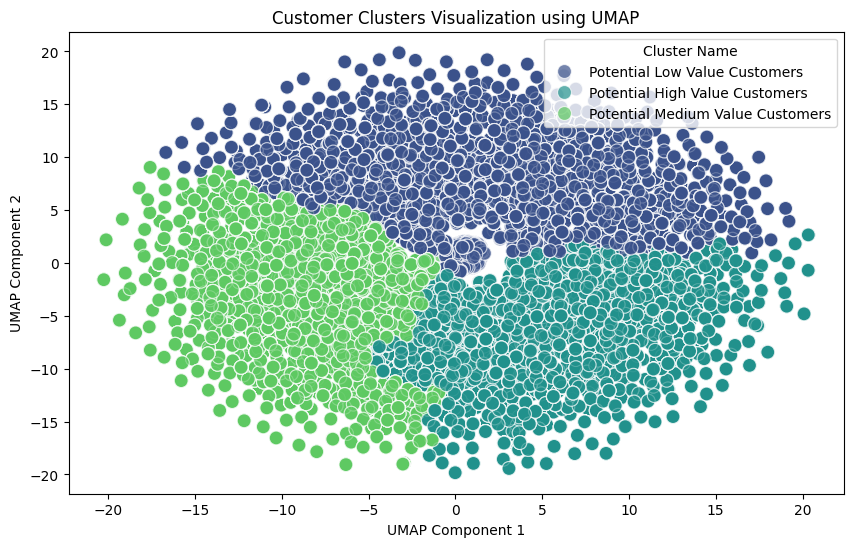

In [10]:
# Visualizing the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Cluster_Name', data=df, palette='viridis', s=100, alpha=0.7)
plt.title('Customer Clusters Visualization using UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster Name', loc='best')
plt.show()

In [11]:
# Cluster analysis: describe statistics and CLV
cluster_analysis = {}
for i in range(3):
    cluster_name = cluster_names.get(i, f'Cluster {i}')
    cluster_data = df[df['Cluster'] == i][numerical_cols].describe()
    cluster_clv_mean = df[df['Cluster'] == i]['CLV'].mean()
    churn_rate = df[df['Cluster'] == i]['Churn'].mean() * 100  # Convert to percentage
    cluster_analysis[cluster_name] = {
        'Data Description': cluster_data,
        'Average CLV': cluster_clv_mean,
        'Churn Rate': churn_rate
    }

# Count the number of records in each cluster
cluster_counts = df['Cluster_Name'].value_counts()

In [12]:
# Results
print("Cluster Analysis Summary:")
for cluster_name, analysis in cluster_analysis.items():
    print(f"\n{cluster_name}:\n")
    print(analysis['Data Description'])
    print(f"Average CLV: {analysis['Average CLV']:.2f}")
    print(f"Churn Rate: {analysis['Churn Rate']:.2f}%")

print("\nNumber of Records in Each Cluster:")
print(cluster_counts)

Cluster Analysis Summary:

Potential Low Value Customers:

       Account_Length  VMail_Message      Day_Mins     Day_Calls  \
count    15503.000000   15503.000000  15503.000000  15503.000000   
mean       145.169645      11.465394    235.934434    148.271560   
std         93.711277      22.526595     56.209719     84.336625   
min          1.000000       0.000000     62.300000     20.000000   
25%         68.000000       0.000000    220.000000     88.000000   
50%        110.000000       0.000000    229.200000    111.000000   
75%        223.000000      22.000000    282.200000    222.000000   
max        329.000000     211.000000    424.400000    329.000000   

         Day_Charge      Eve_Mins     Eve_Calls    Eve_Charge    Night_Mins  \
count  15503.000000  15503.000000  15503.000000  15503.000000  15503.000000   
mean      38.292609    246.168191    146.944075     23.797523    248.097902   
std       22.586934     44.377967     82.809530      8.532714     43.471001   
min        6